In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy 

import textwrap

import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now..
try:
    import graphviz
except ModuleNotFoundError as e:
    import pip
    pip.main(["install","graphviz"])
    import graphviz

from typing import Union

root_path = root_path = os.path.realpath('../../../..')
# print(root_path)
try:
    import causaltune
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "causaltune"))

from sklearn.model_selection import train_test_split
from causaltune import CausalTune
from causaltune.data_utils import CausalityDataset
from causaltune.datasets import generate_synthetic_data

# Import linear synthetic data creation
from causaltune.datasets import generate_linear_synthetic_data

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# set a few params
metrics = [
    "frobenius_norm",
    "prob_erupt",
    "policy_risk",
    "codec",
    "energy_distance", 
    "psw_energy_distance"
    ]
    
n_samples = 5000
test_size = 0.33 # equal train,val,test
#time_budget = 21600
components_time_budget = 60

estimator_list = [
             "Dummy",
             "SparseLinearDML",
             "ForestDRLearner",
             "TransformedOutcome",
             "CausalForestDML",
             ".LinearDML",
             "DomainAdaptationLearner",
             "SLearner",
             "XLearner",
             "TLearner",
             "Ortho"        
    ] 

n_runs = 1
out_dir = ""
filename_out = "Test" 

# 1. Dataset Generation

In [3]:
# Create empty dictionary
data_sets = {}

### 1.1 Non-linear Data
Unkown Confounders (RCT), Known Confoudners (Observational), IV

In [4]:
cd_non_linear = generate_synthetic_data(n_samples=n_samples, confounding=False, noisy_outcomes=True)
cd_non_linear.preprocess_dataset()
data_sets['Unknown_Confounders_non-linear'] = cd_non_linear

In [5]:
cd_non_linear = generate_synthetic_data(n_samples=n_samples, confounding=True, noisy_outcomes=True)
cd_non_linear.preprocess_dataset()
data_sets['Known_Confounders_non-linear'] = cd_non_linear

In [6]:
#cd_non_linear = generate_synthetic_data(n_samples=n_samples, confounding=True, add_instrument=True)
#cd_non_linear.preprocess_dataset()
#data_sets['IV_non-linear'] = cd_non_linear
#cd_linear.data.head(5)

### 1.2 Linear Data
Unkown Confounders (RCT), Known Confoudners (Observational), IV

In [7]:
cd_linear = generate_linear_synthetic_data(n_samples=n_samples, confounding=False, noisy_outcomes=True)
cd_linear.preprocess_dataset()
data_sets['Unknown_Confounders_linear'] = cd_linear

In [8]:
cd_linear = generate_linear_synthetic_data(n_samples=n_samples, confounding=True, noisy_outcomes=True)
cd_linear.preprocess_dataset()
data_sets['Known_Confounders_linear'] = cd_linear

In [9]:
#cd_linear = generate_linear_synthetic_data(n_samples=n_samples, confounding=True, add_instrument=True)
#cd_linear.preprocess_dataset()
#data_sets['IV_linear'] = cd_linear
#cd_linear.data.head(5)

# 2. Model Fitting

In [ ]:
import time

run_times = {}

start_time = time.time()

for dataset_name, cd in data_sets.items():
    
    for i_run in range(1,n_runs+1):
        
        cd_i = copy.deepcopy(cd)
        train_df, test_df = train_test_split(cd_i.data, test_size=test_size)
        test_df = test_df.reset_index(drop=True)
        cd_i.data = train_df
        
        for metric in metrics:

            print("___________________________________________________________________________")
            print("EVALUATING: ", metric)
    
            start_time_metric = time.time()
            
            ct = CausalTune(
                metric=metric,
                verbose=1,
                components_verbose=1,
                components_time_budget=components_time_budget,
                estimator_list=estimator_list,
                store_all_estimators=True,
            )

            ct.fit(
                data=cd_i,
                treatment="treatment",
                outcome="outcome",
            )

            # compute relevant scores (skip newdummy)
            datasets = {"train": ct.train_df, "validation": ct.test_df, "test": test_df}
            # get scores on train,val,test for each trial, 
            # sort trials by validation set performance
            # assign trials to estimators
            estimator_scores = {est: [] for est in ct.scores.keys() if "NewDummy" not in est}
            for trial in ct.results.trials:
                # estimator name:
                estimator_name = trial.last_result["estimator_name"]
                if  trial.last_result["estimator"]:
                    estimator = trial.last_result["estimator"]
                    scores = {}
                    for ds_name, df in datasets.items():
                        scores[ds_name] = {}
                        # make scores
                        est_scores = ct.scorer.make_scores(
                            estimator,
                            df,
                            metrics_to_report=ct.metrics_to_report,
                        )

                        # add cate:
                        scores[ds_name]["CATE_estimate"] = estimator.estimator.effect(df)
                        # add ground truth for convenience
                        scores[ds_name]["CATE_groundtruth"] = df["true_effect"]
                        scores[ds_name][metric] = est_scores[metric]
                    estimator_scores[estimator_name].append(scores)


            # sort trials by validation performance
            for k in estimator_scores.keys():
                estimator_scores[k] = sorted(
                    estimator_scores[k],
                    key=lambda x: x["validation"][metric],
                    reverse=False if metric in ["energy_distance", "psw_energy_distance", "codec"] else True,
                )

            end_time_metric = time.time()
            compute_time_metric = end_time_metric - start_time_metric
    
            print(f"COMPUTE TIME METRIC: {compute_time_metric} seconds")

            run_times[metric]=compute_time_metric

            results = {
                "best_estimator": ct.best_estimator,
                "best_config": ct.best_config,
                "best_score": ct.best_score,
                "optimised_metric": metric,
                "scores_per_estimator": estimator_scores,
                "run_time": compute_time_metric
            }

            with open(f"{out_dir}{filename_out}_{metric}_run_{i_run}_{dataset_name}.pkl", "wb") as f:
                pickle.dump(results, f)
            
            print("DONE WITH METRIC...")
    
            print("___________________________________________________________________________")


end_time = time.time()
total_time = end_time - start_time
print("TOTAL RUNTIME: ",total_time)



[flaml.tune.tune: 07-21 13:34:39] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 07-21 13:34:39] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}


___________________________________________________________________________
EVALUATING:  frobenius_norm
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.4

[flaml.tune.tune: 07-21 13:34:39] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 07-21 13:34:39] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 07-21 13:35:39] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}
[flaml.tune.tune: 07-21 13:37:42] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}
[flaml.tune.tune: 07-21 13:41:45] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-21 13:44:49] {636} INFO - trial 7 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_de

COMPUTE TIME METRIC: 1693.6220703125 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  prob_erupt
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5

[flaml.tune.tune: 07-21 14:02:52] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 07-21 14:02:53] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 07-21 14:03:53] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}
[flaml.tune.tune: 07-21 14:05:56] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}
[flaml.tune.tune: 07-21 14:10:00] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-21 14:13:05] {636} INFO - trial 7 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_de

COMPUTE TIME METRIC: 1685.932246685028 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  policy_risk
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf'

[flaml.tune.tune: 07-21 14:30:58] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 07-21 14:30:58] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 07-21 14:31:59] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}
[flaml.tune.tune: 07-21 14:34:02] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}
[flaml.tune.tune: 07-21 14:38:06] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-21 14:41:09] {636} INFO - trial 7 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_de

COMPUTE TIME METRIC: 1695.2250826358795 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  codec
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 

[flaml.tune.tune: 07-21 14:59:14] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 07-21 14:59:14] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 07-21 15:00:14] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}
[flaml.tune.tune: 07-21 15:02:17] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}
[flaml.tune.tune: 07-21 15:06:21] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-21 15:09:25] {636} INFO - trial 7 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_de

COMPUTE TIME METRIC: 1695.0262792110443 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  energy_distance
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_

[flaml.tune.tune: 07-21 15:27:29] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 07-21 15:27:29] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 07-21 15:28:30] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}
[flaml.tune.tune: 07-21 15:30:33] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}
[flaml.tune.tune: 07-21 15:34:38] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-21 15:37:42] {636} INFO - trial 7 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_de

COMPUTE TIME METRIC: 1321.18718791008 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  psw_energy_distance
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_sample

[flaml.tune.tune: 07-21 15:49:30] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 07-21 15:49:30] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 07-21 15:50:30] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}
[flaml.tune.tune: 07-21 15:52:33] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}
[flaml.tune.tune: 07-21 15:56:37] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-21 15:59:41] {636} INFO - trial 7 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_de

COMPUTE TIME METRIC: 1319.8395869731903 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  frobenius_norm
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_l

[flaml.tune.tune: 07-21 16:11:30] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 07-21 16:11:30] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 07-21 16:12:31] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}
[flaml.tune.tune: 07-21 16:14:34] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}
[flaml.tune.tune: 07-21 16:18:38] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-21 16:21:44] {636} INFO - trial 7 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_de

COMPUTE TIME METRIC: 1680.7679126262665 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  prob_erupt
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf'

[flaml.tune.tune: 07-21 16:39:30] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 07-21 16:39:31] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 07-21 16:40:31] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}
[flaml.tune.tune: 07-21 16:42:35] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}
[flaml.tune.tune: 07-21 16:46:39] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-21 16:49:44] {636} INFO - trial 7 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_de

COMPUTE TIME METRIC: 1683.8773739337921 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  policy_risk
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf

[flaml.tune.tune: 07-21 17:07:34] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 07-21 17:07:34] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 07-21 17:08:35] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}
[flaml.tune.tune: 07-21 17:10:39] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}
[flaml.tune.tune: 07-21 17:14:43] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-21 17:17:48] {636} INFO - trial 7 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_de

COMPUTE TIME METRIC: 1692.9166989326477 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  codec
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 

[flaml.tune.tune: 07-21 17:35:47] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 07-21 17:35:47] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 07-21 17:36:50] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}
[flaml.tune.tune: 07-21 17:38:53] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}
[flaml.tune.tune: 07-21 17:42:57] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-21 17:46:02] {636} INFO - trial 7 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_de

COMPUTE TIME METRIC: 1682.7804009914398 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  energy_distance
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_

[flaml.tune.tune: 07-21 18:03:50] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 07-21 18:03:50] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 07-21 18:04:51] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}
[flaml.tune.tune: 07-21 18:06:54] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}
[flaml.tune.tune: 07-21 18:10:59] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-21 18:14:04] {636} INFO - trial 7 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_de

COMPUTE TIME METRIC: 1686.0587844848633 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  psw_energy_distance
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samp

[flaml.tune.tune: 07-21 18:31:56] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 07-21 18:31:56] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 07-21 18:32:57] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}
[flaml.tune.tune: 07-21 18:35:00] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}
[flaml.tune.tune: 07-21 18:39:05] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-21 18:42:11] {636} INFO - trial 7 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_de

COMPUTE TIME METRIC: 1688.2225139141083 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  frobenius_norm
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_l

[flaml.tune.tune: 07-21 19:00:04] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 07-21 19:00:04] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 07-21 19:01:05] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}
[flaml.tune.tune: 07-21 19:03:08] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}
[flaml.tune.tune: 07-21 19:07:12] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-21 19:10:16] {636} INFO - trial 7 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_de

COMPUTE TIME METRIC: 1797.3655354976654 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  prob_erupt
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf'

[flaml.tune.tune: 07-21 19:30:02] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 07-21 19:30:02] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 07-21 19:31:02] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}
[flaml.tune.tune: 07-21 19:33:06] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}
[flaml.tune.tune: 07-21 19:37:10] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-21 19:40:14] {636} INFO - trial 7 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_de

COMPUTE TIME METRIC: 1691.5004913806915 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  policy_risk
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf

[flaml.tune.tune: 07-21 19:58:13] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 07-21 19:58:13] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 07-21 19:59:15] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}
[flaml.tune.tune: 07-21 20:01:18] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}
[flaml.tune.tune: 07-21 20:05:22] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-21 20:08:26] {636} INFO - trial 7 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_de

COMPUTE TIME METRIC: 1677.5988235473633 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  codec
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 

[flaml.tune.tune: 07-21 20:26:11] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 07-21 20:26:11] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 07-21 20:27:11] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}
[flaml.tune.tune: 07-21 20:29:15] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}
[flaml.tune.tune: 07-21 20:33:19] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-21 20:36:24] {636} INFO - trial 7 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_de

COMPUTE TIME METRIC: 1697.605623960495 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  energy_distance
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_l

[flaml.tune.tune: 07-21 20:54:28] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 07-21 20:54:29] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 07-21 20:55:30] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}
[flaml.tune.tune: 07-21 20:57:33] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}
[flaml.tune.tune: 07-21 21:01:37] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-21 21:04:41] {636} INFO - trial 7 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_de

COMPUTE TIME METRIC: 1696.7376942634583 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  psw_energy_distance
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samp

[flaml.tune.tune: 07-21 21:22:45] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 07-21 21:22:45] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 07-21 21:23:46] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}
[flaml.tune.tune: 07-21 21:25:49] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}
[flaml.tune.tune: 07-21 21:29:53] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-21 21:32:57] {636} INFO - trial 7 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_de

COMPUTE TIME METRIC: 1697.6261417865753 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  frobenius_norm
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_l

[flaml.tune.tune: 07-21 21:51:03] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 07-21 21:51:03] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 07-21 21:52:05] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}
[flaml.tune.tune: 07-21 21:54:08] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}


FileNotFoundError: [Errno 2] No such file or directory: 'Test_frobenius_norm_run_1_Known_Confounders_linear.pkl'

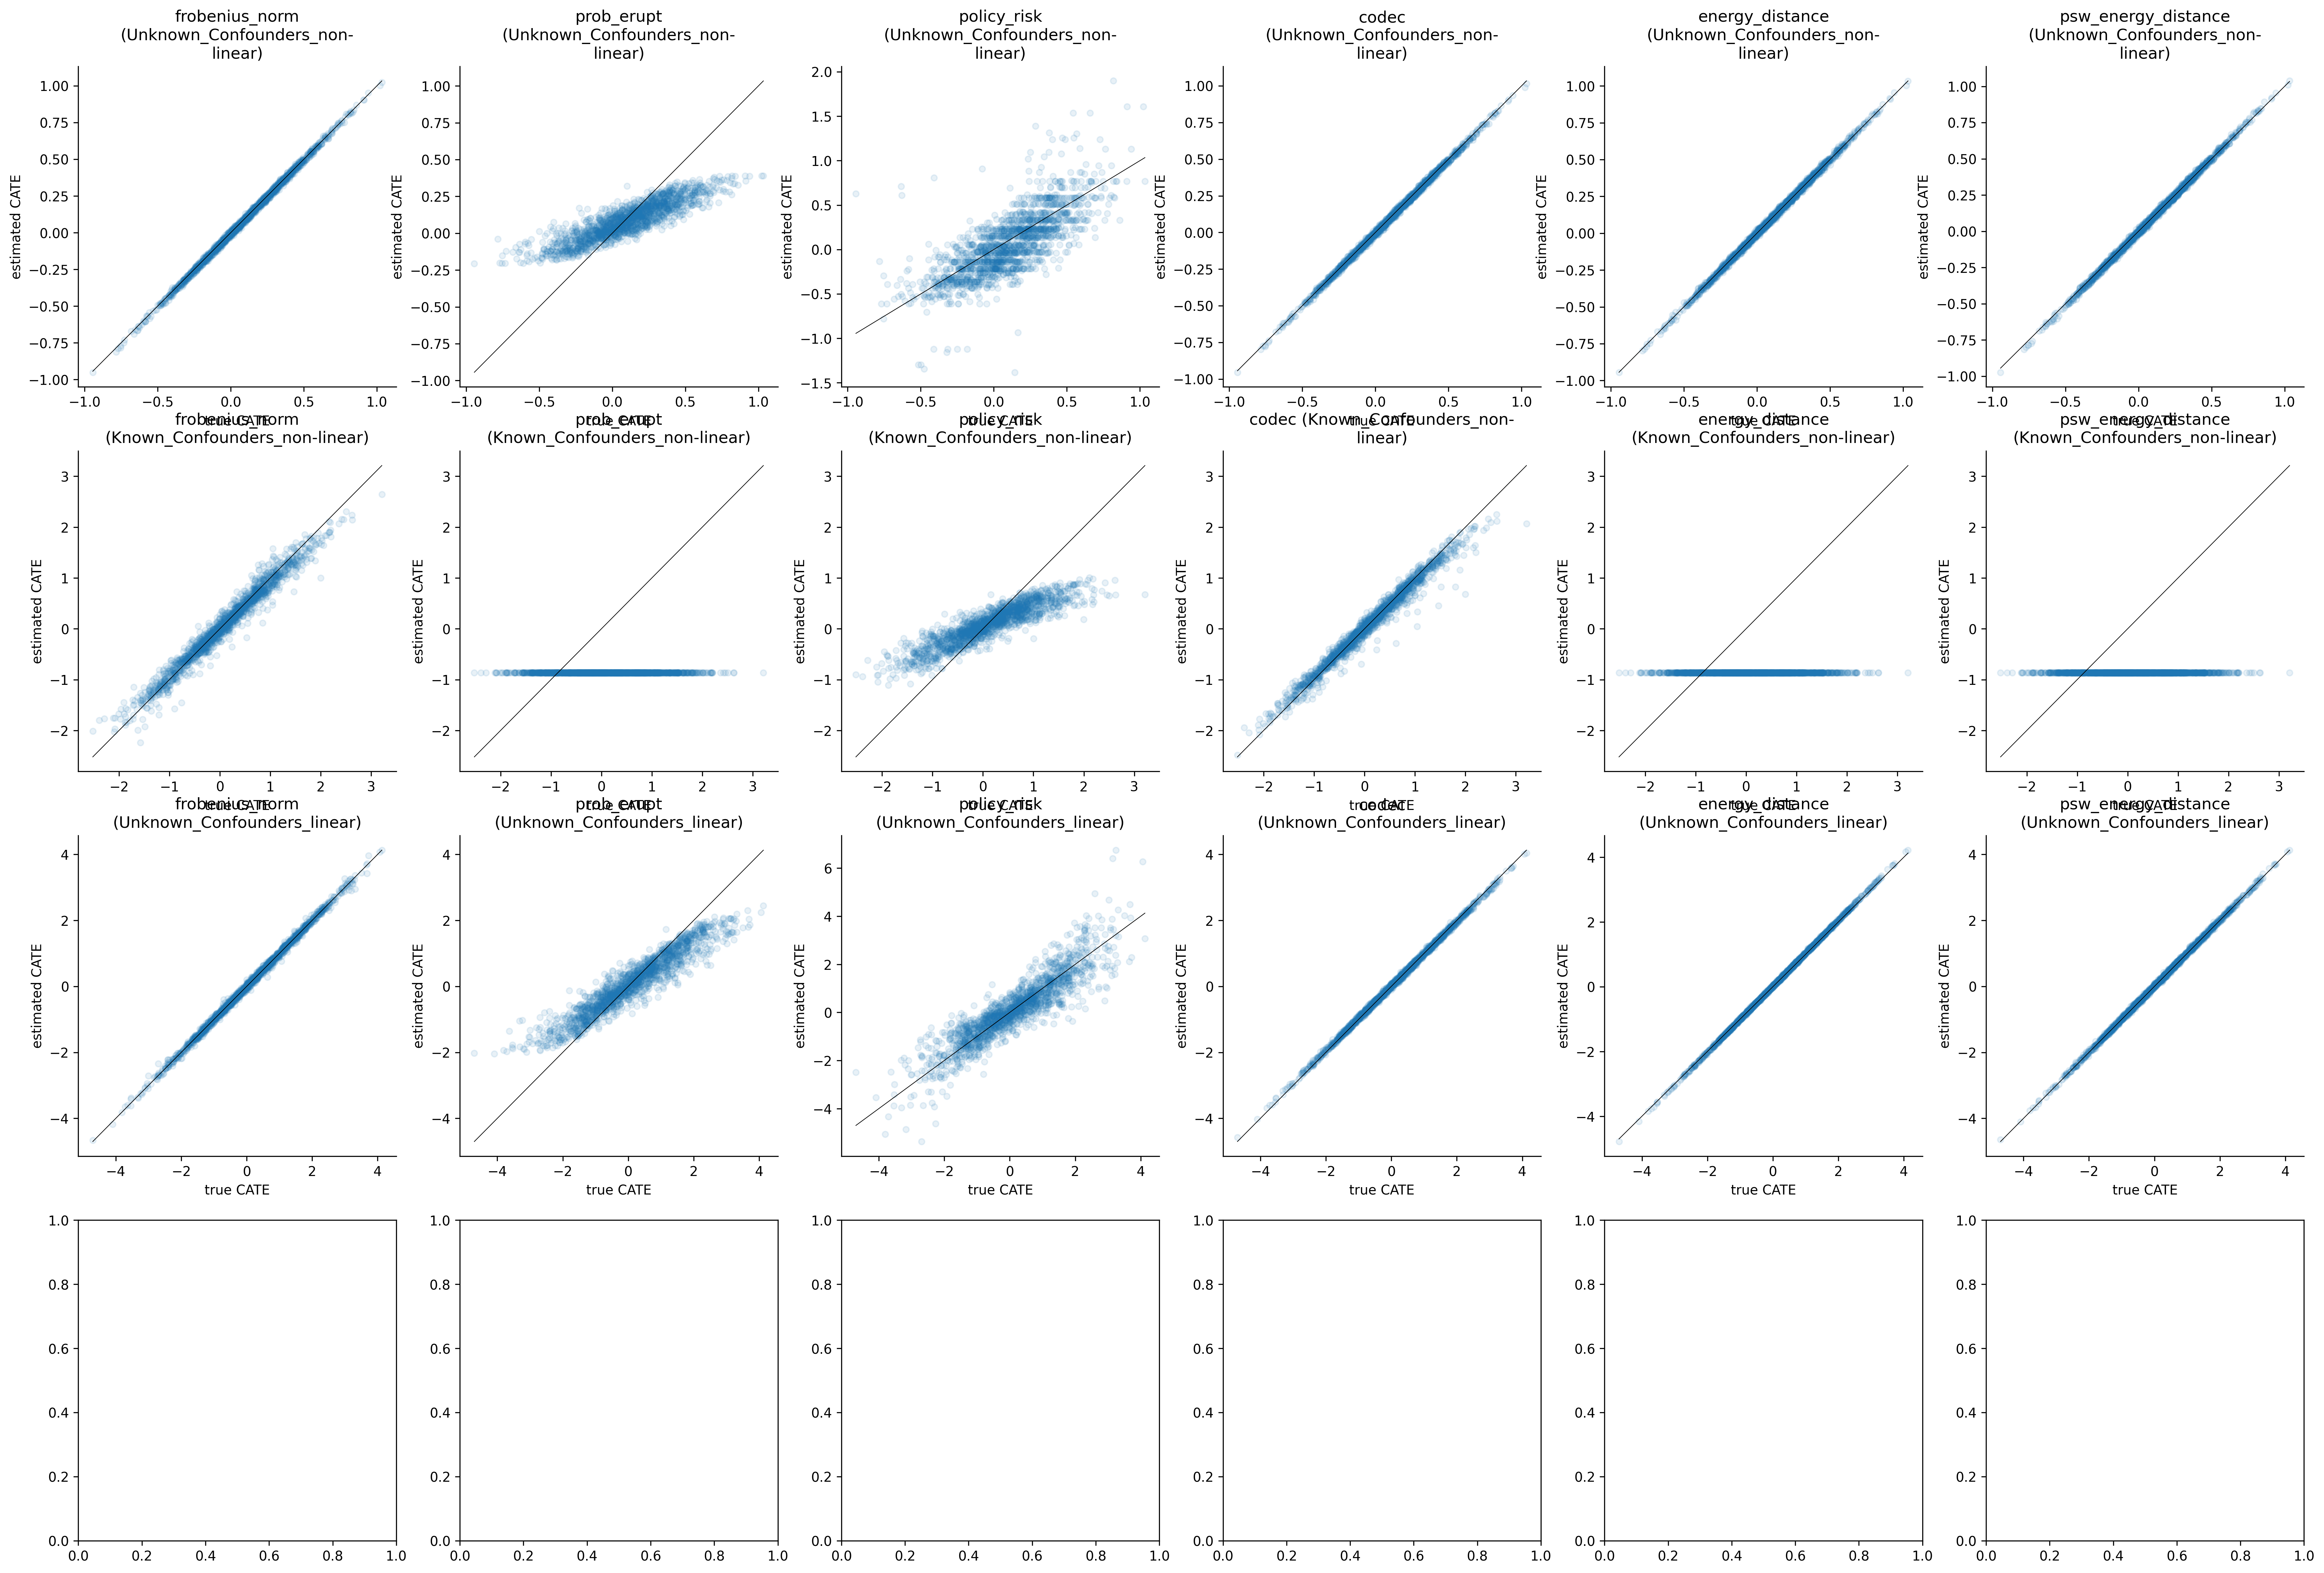

In [11]:
%matplotlib inline

# Define list of experiments to iterate over
trials = list(data_sets.keys())

# Define the number of rows and columns for the subplots
n_rows = len(trials)
n_cols = len(metrics)

# Create subplots
f, axs = plt.subplots(n_rows, n_cols, figsize=(30, 5 * n_rows), dpi=300)

# If there's only one row or one column, axs won't be a 2D array, so we need to handle that
if n_rows == 1 and n_cols == 1:
    axs = [[axs]]
elif n_rows == 1:
    axs = [axs]
elif n_cols == 1:
    axs = [[ax] for ax in axs]

best_estimators = []

# Plot true against estimated for best estimator
for row, trial in enumerate(trials):
    for col, metric in enumerate(metrics):
        ax = axs[row][col]
        with open(f"{out_dir}{filename_out}_{metric}_run_1_{trial}.pkl", "rb") as f:
            results = pickle.load(f)

        best_estimators.append(results["best_estimator"])

        CATE_gt = results["scores_per_estimator"][results["best_estimator"]][0]["test"]["CATE_groundtruth"]
        CATE_est = results["scores_per_estimator"][results["best_estimator"]][0]["test"]["CATE_estimate"]

        ax.scatter(CATE_gt, CATE_est, s=20, alpha=0.1)
        ax.plot([min(CATE_gt), max(CATE_gt)], [min(CATE_gt), max(CATE_gt)], "k-", linewidth=0.5)
        ax.set_xlabel("true CATE")
        ax.set_ylabel("estimated CATE")
        
        # Wrap the title text to a specific width
        title_text = f"{results['optimised_metric']} ({trial})"
        wrapped_title = "\n".join(textwrap.wrap(title_text, width=30))  # Adjust the width as needed
        ax.set_title(wrapped_title)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig(f"paper_{filename_out}_scores.pdf",format="pdf")
plt.show()

In [13]:
display(best_estimators)

['backdoor.econml.dml.SparseLinearDML',
 'backdoor.econml.dr.ForestDRLearner',
 'backdoor.causaltune.models.TransformedOutcome',
 'backdoor.econml.dml.SparseLinearDML',
 'backdoor.econml.dml.LinearDML',
 'backdoor.econml.dml.LinearDML',
 'backdoor.econml.metalearners.DomainAdaptationLearner',
 'backdoor.causaltune.models.NaiveDummy',
 'backdoor.econml.dr.ForestDRLearner',
 'backdoor.econml.metalearners.DomainAdaptationLearner',
 'backdoor.causaltune.models.NaiveDummy',
 'backdoor.causaltune.models.NaiveDummy',
 'backdoor.econml.metalearners.XLearner',
 'backdoor.econml.dml.CausalForestDML',
 'backdoor.causaltune.models.TransformedOutcome',
 'backdoor.econml.dml.SparseLinearDML',
 'backdoor.econml.dml.SparseLinearDML',
 'backdoor.econml.dml.SparseLinearDML']